# Task 3: Supervised Learning

We first import the necessary packages. 

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from pandas.plotting import table

Let's load our dataset. and create our features and label tables

In [2]:
df = pd.read_csv('clean_data.csv')

feature_names = df.filter(regex='symptom:*', axis=1).columns
X = np.array(df.filter(regex='symptom:*', axis=1))
Y = df['hospitalized_new']

Let's also make sure that everything is reproducible by setting a seed. (sklearn using np's random)

In [3]:
np.random.seed(0)

**1 - Split the Data**

We're trying to see if we can predict the number of new cases using supervised learning. As described in the assignment, we will split the data in two different ways: 

1. By regions. We will keep 20% of the regions in a validation set and train on the rest. (This works well because the amount of data in each region is equal). To prepare for later sections, we have created 5 splits in foresight of making a 5-fold cross validation later.

2. By date. We will keep data after '2020-08-10' as a validation set and train on the rest.

In [4]:
# Create list of sets for 5fold based on region code

print('\n5Fold region based splits:')
region_sets_list = []
kf = GroupKFold(n_splits=5)
for train_index, test_index in kf.split(X, Y, df['open_covid_region_code']):
    region_sets_list.append([X[train_index], X[test_index], Y[train_index], Y[test_index]])
    print(len(train_index), len(test_index))

# Create sets based on timepoint
print('\nDate based split:')
train_index = df['date'] <= '2020-08-10'
test_index = [not i for i in train_index]
date_sets = [X[train_index], X[test_index], Y[train_index], Y[test_index]]
print(len(Y[train_index]), len(Y[test_index]))


5Fold region based splits:
192 36
174 54
175 53
176 52
195 33

Date based split:
172 56


We can see that the in each of the different split methods, the dataset adheres to train-set test-set splits that are near the 80-20 ratio.

**2 - Regression**

We must compare the regression performance between KKNs and decision trees for each of the split strategies.

Let's first define a function to plot the Mean Absolute Error and R2 of our training

In [5]:
def plot_training(l, error_test, error_train, r2_test, r2_train, title, xlab):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,6))
    fig.suptitle(title)

    ax1.plot(l, error_test, '-', label='Validation')
    ax1.plot(l, error_train, '-', label='Train')
    ax1.legend()
    ax1.set(ylabel='Mean Absolute Error')

    ax2.plot(l, r2_test, '-', label='Validation')
    ax2.plot(l, r2_train, '-', label='Train')
    ax2.legend()
    ax2.set(xlabel=xlab, ylabel='R2 (Coefficient of Determination)', xticks = l)

    plt.show()

We first begin by testing a KNN and choosing using 5-fold cross validation using the region split strategy. We are training and testing different K values to find the best hyperparamater for our dataset.

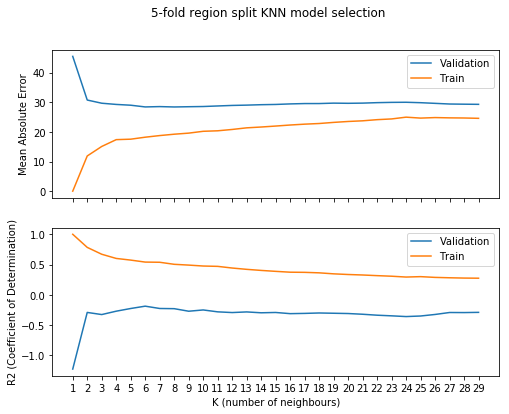

In [6]:
error_train = []
error_test = []
r2_train = []
r2_test = []

K_list = range(1,30)
for k in K_list:
    error_train_sum, error_test_sum, r2_train_sum, r2_test_sum = 0,0,0,0
    for split in region_sets_list:
        x_train, x_test, y_train, y_test = split
        model = neighbors.KNeighborsRegressor(n_neighbors=k)
        model = model.fit(x_train, y_train)
        preds_train = model.predict(x_train)
        preds_test = model.predict(x_test)
        error_train_sum += mean_absolute_error(y_train, preds_train)
        error_test_sum += mean_absolute_error(y_test, preds_test)
        r2_train_sum += r2_score(y_train, preds_train)
        r2_test_sum += r2_score(y_test, preds_test)
    
    error_train.append(error_train_sum/len(region_sets_list))
    error_test.append(error_test_sum/len(region_sets_list))
    r2_train.append(r2_train_sum/len(region_sets_list))
    r2_test.append(r2_test_sum/len(region_sets_list))

plot_training(K_list, error_test, error_train, r2_test, r2_train, '5-fold region split KNN model selection', 'K (number of neighbours)')

By looking at the above graph of model performances using 5 fold cross validation, we are choosing the final model to have a K of 6, as the training set and validation performance seems to be the best around there. One thing to note is that the R2 score never reaches above 0. This means that this model is no better than a linear model of the test data, which is not great news for us, as it's saying that the model is incapable of learning much of the test sets. Even worse is the fact that this is already the cross-validated model, so it cannot be described by data imbalance between our test set and training set. 

Next, we test KNN with the date split method.

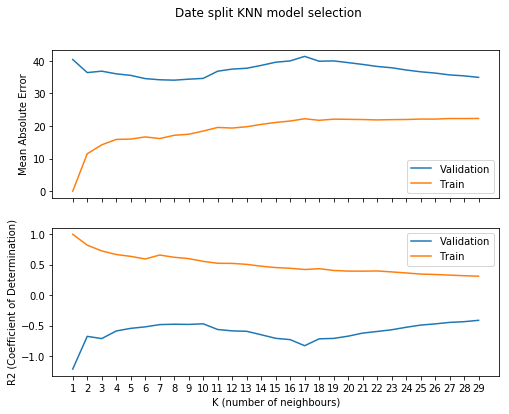

In [7]:
error_train = []
error_test = []
r2_train = []
r2_test = []

K_list = range(1,30)
for k in K_list:
    x_train, x_test, y_train, y_test = date_sets
    model = neighbors.KNeighborsRegressor(n_neighbors=k)
    model = model.fit(x_train, y_train)
    preds_train = model.predict(x_train)
    preds_test = model.predict(x_test)
    error_train.append(mean_absolute_error(y_train, preds_train))
    error_test.append(mean_absolute_error(y_test, preds_test))
    r2_train.append(r2_score(y_train, preds_train))
    r2_test.append(r2_score(y_test, preds_test))


plot_training(K_list, error_test, error_train, r2_test, r2_train, 'Date split KNN model selection', 'K (number of neighbours)')

We decided to use the same K as the 5-fold method for our final models.

Next, we do hyperparameter tuning with Decision Tree Regression.

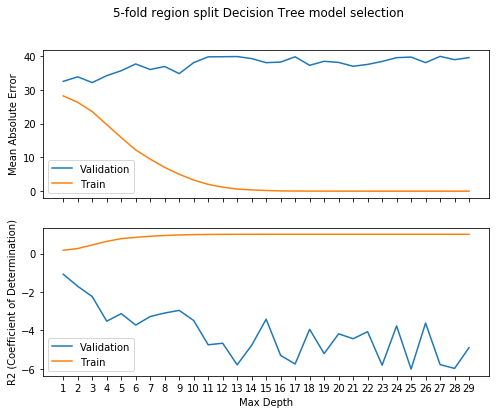

In [8]:
error_train = []
error_test = []
r2_train = []
r2_test = []

D_list = range(1,30)
for d in D_list:
    error_train_sum, error_test_sum, r2_train_sum, r2_test_sum = 0,0,0,0
    for split in region_sets_list:
        x_train, x_test, y_train, y_test = split
        model = DecisionTreeRegressor(max_depth = d)
        model = model.fit(x_train, y_train)
        preds_train = model.predict(x_train)
        preds_test = model.predict(x_test)
        error_train_sum += mean_absolute_error(y_train, preds_train)
        error_test_sum += mean_absolute_error(y_test, preds_test)
        r2_train_sum += r2_score(y_train, preds_train)
        r2_test_sum += r2_score(y_test, preds_test)
    
    error_train.append(error_train_sum/len(region_sets_list))
    error_test.append(error_test_sum/len(region_sets_list))
    r2_train.append(r2_train_sum/len(region_sets_list))
    r2_test.append(r2_test_sum/len(region_sets_list))

plot_training(D_list, error_test, error_train, r2_test, r2_train, '5-fold region split Decision Tree model selection', 'Max Depth')

We can see that the Decision Tree model rapidly overfits the training set as the dpeth increases. We want to reduce this as much as possible. However, we also want out tree to have some kind of depth and not just have two leaves with depth = 1.

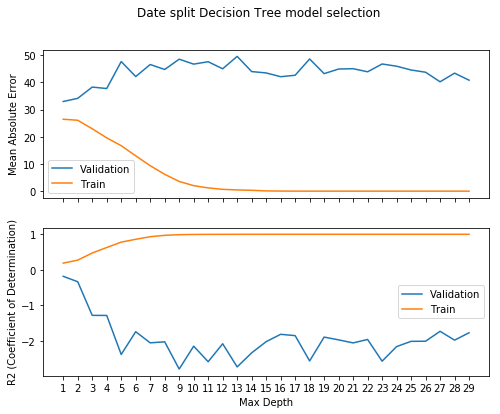

In [9]:
error_train = []
error_test = []
r2_train = []
r2_test = []

D_list = range(1,30)
for d in D_list:
    x_train, x_test, y_train, y_test = date_sets
    model = DecisionTreeRegressor(max_depth = d)
    model = model.fit(x_train, y_train)
    preds_train = model.predict(x_train)
    preds_test = model.predict(x_test)
    error_train.append(mean_absolute_error(y_train, preds_train))
    error_test.append(mean_absolute_error(y_test, preds_test))
    r2_train.append(r2_score(y_train, preds_train))
    r2_test.append(r2_score(y_test, preds_test))


plot_training(D_list, error_test, error_train, r2_test, r2_train, 'Date split Decision Tree model selection', 'Max Depth')


Similar to above, we decided to use a depth of 6 for our final model, in which there is a slight peak in both split types.

As an additional model to test, we decided to try the same conditions using a new model: the Random Forest Regression model. Random Forest consists of using many decision trees as an ensemble. It will generate many trees based on random feature sets, and produce a consensus which will become the result. This helps the model become more generalized and protect against individual errors in its decision trees. 

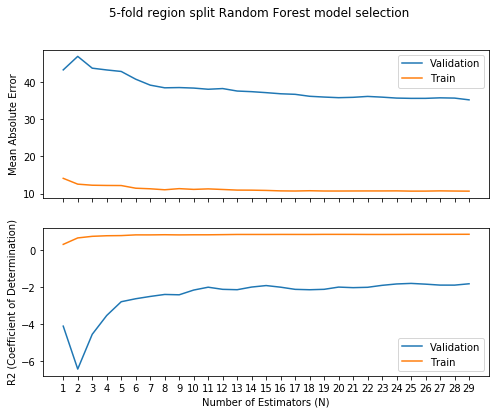

In [10]:
error_train = []
error_test = []
r2_train = []
r2_test = []

N_list = range(1,30)
for n in N_list:
    error_train_sum, error_test_sum, r2_train_sum, r2_test_sum = 0,0,0,0
    for split in region_sets_list:
        x_train, x_test, y_train, y_test = split
        model = RandomForestRegressor(n_estimators=n, random_state=0)
        model = model.fit(x_train, y_train)
        preds_train = model.predict(x_train)
        preds_test = model.predict(x_test)
        error_train_sum += mean_absolute_error(y_train, preds_train)
        error_test_sum += mean_absolute_error(y_test, preds_test)
        r2_train_sum += r2_score(y_train, preds_train)
        r2_test_sum += r2_score(y_test, preds_test)
    
    error_train.append(error_train_sum/len(region_sets_list))
    error_test.append(error_test_sum/len(region_sets_list))
    r2_train.append(r2_train_sum/len(region_sets_list))
    r2_test.append(r2_test_sum/len(region_sets_list))
    

plot_training(N_list, error_test, error_train, r2_test, r2_train, '5-fold region split Random Forest model selection', 'Number of Estimators (N)')


Although we can see that the model doesn't suffer from the rapid overfitting of the Decision Tree model, it does not seem to improve the validation accuracy by much either. Date split below gives similar results. We choose 25 for our number of estimators.

error_train = []
error_test = []
r2_train = []
r2_test = []

N_list = range(1,30)
for n in N_list:
    x_train, x_test, y_train, y_test = date_sets
    model = RandomForestRegressor(n_estimators=n, random_state=0)
    model = model.fit(x_train, y_train)
    preds_train = model.predict(x_train)
    preds_test = model.predict(x_test)
    error_train.append(mean_absolute_error(y_train, preds_train))
    error_test.append(mean_absolute_error(y_test, preds_test))
    r2_train.append(r2_score(y_train, preds_train))
    r2_test.append(r2_score(y_test, preds_test))
    
    
plot_training(N_list, error_test, error_train, r2_test, r2_train, 'Date split Random Forest model selection', 'Number of Estimators (N)')


**3. Test** 

Now, let's train, test and compare our models with our chosen parameters.

In [11]:
# KNN 5fold region split
k = 6
error_sum = 0
r2_sum = 0
for split in region_sets_list:
    x_train, x_test, y_train, y_test = split
    model = neighbors.KNeighborsRegressor(n_neighbors=k)
    model = model.fit(x_train, y_train)
    error_sum += mean_absolute_error(y_test, model.predict(x_test))
    r2_sum += r2_score(y_test, model.predict(x_test))
error_KNN_region = error_sum/len(region_sets_list)
r2_KNN_region = r2_sum/len(region_sets_list)

# KNN date split
x_train, x_test, y_train, y_test = date_sets
model = neighbors.KNeighborsRegressor(n_neighbors=k)
model = model.fit(x_train, y_train)
error_KNN_date = mean_absolute_error(y_test, model.predict(x_test))
r2_KNN_date = r2_score(y_test, model.predict(x_test))

# Decision Tree 5fold region split
d = 6
error_sum = 0
r2_sum = 0
for split in region_sets_list:
    x_train, x_test, y_train, y_test = split
    model = DecisionTreeRegressor(max_depth = d)
    model = model.fit(x_train, y_train)
    error_sum += mean_absolute_error(y_test, model.predict(x_test))
    r2_sum += r2_score(y_test, model.predict(x_test))
error_DT_region = error_sum/len(region_sets_list)
r2_DT_region = r2_sum/len(region_sets_list)
    
# Decision Tree date split
x_train, x_test, y_train, y_test = date_sets
model = DecisionTreeRegressor(max_depth = d)
model = model.fit(x_train, y_train)
error_DT_date = mean_absolute_error(y_test, model.predict(x_test))
r2_DT_date = r2_score(y_test, model.predict(x_test))

# Random Forest 5fold region split
n = 25
error_sum = 0
r2_sum = 0
for split in region_sets_list:
    x_train, x_test, y_train, y_test = split
    model = RandomForestRegressor(n_estimators=n, random_state=0)
    model = model.fit(x_train, y_train)
    error_sum += mean_absolute_error(y_test, model.predict(x_test))
    r2_sum += r2_score(y_test, model.predict(x_test))
error_RF_region = error_sum/len(region_sets_list)
r2_RF_region = r2_sum/len(region_sets_list)

# Random Forest date split
x_train, x_test, y_train, y_test = date_sets
model = RandomForestRegressor(n_estimators=n, random_state=0)
model = model.fit(x_train, y_train)
error_RF_date = mean_absolute_error(y_test, model.predict(x_test))
r2_RF_date = r2_score(y_test, model.predict(x_test))

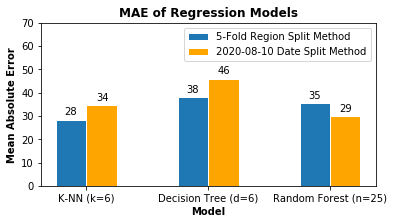

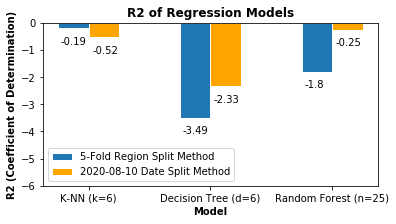

In [12]:
error_results = [[error_KNN_region, error_DT_region, error_RF_region], [error_KNN_date, error_DT_date, error_RF_date]]
r2_results = [[r2_KNN_region, r2_DT_region, r2_RF_region], [r2_KNN_date, r2_DT_date, r2_RF_date]]

barWidth = 0.25
r1 = np.arange(len(error_results[0])) + barWidth/2
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(6,3))
plt.bar(r1, error_results[0], color='tab:blue', width=barWidth, edgecolor='white', label='5-Fold Region Split Method')
plt.bar(r2, error_results[1], color='orange', width=barWidth, edgecolor='white', label='2020-08-10 Date Split Method')

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(error_results[0]))], ['K-NN (k='+str(k)+')', 'Decision Tree (d='+str(d)+')', 'Random Forest (n='+str(n)+')'])
plt.ylabel('Mean Absolute Error', fontweight='bold')
plt.ylim(top=70)
plt.title("MAE of Regression Models", fontweight='bold')
xlocs, xlabs = plt.xticks()
for i, v in enumerate(error_results[0]):
    plt.text(xlocs[i] - 0.18, v + 2, str(int(v)))
for i, v in enumerate(error_results[1]):
    plt.text(xlocs[i] + 0.08, v + 2, str(int(v)))
plt.legend()
plt.show()

plt.figure(figsize=(6,3))
plt.bar(r1, r2_results[0], color='tab:blue', width=barWidth, edgecolor='white', label='5-Fold Region Split Method')
plt.bar(r2, r2_results[1], color='orange', width=barWidth, edgecolor='white', label='2020-08-10 Date Split Method')

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(r2_results[0]))], ['K-NN (k='+str(k)+')', 'Decision Tree (d='+str(d)+')', 'Random Forest (n='+str(n)+')'])
plt.ylabel('R2 (Coefficient of Determination)', fontweight='bold')
plt.title("R2 of Regression Models", fontweight='bold')
plt.ylim(bottom=-6)
xlocs, xlabs = plt.xticks()
for i, v in enumerate(r2_results[0]):
    plt.text(xlocs[i] - 0.23, v - 0.6, str(np.round(v, 2)))
for i, v in enumerate(r2_results[1]):
    plt.text(xlocs[i] + 0.03, v - 0.6, str(np.round(v, 2)))
plt.legend()
plt.show()

And here are our results, plotted. It appears that the K-NN is the best model overall, beating the Random Forest model by a tiny bit. More thorough discussion is in the report.

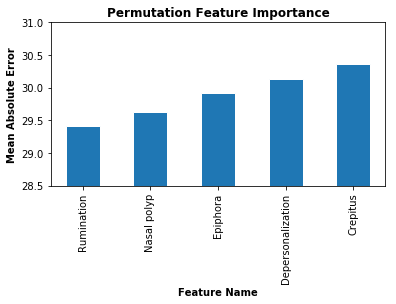

In [13]:
errors_array = []
for i in range(len(feature_names)):
    new_sets_list = []
    for split in region_sets_list:
        x_train, x_test, y_train, y_test = split
        new_sets_list.append([np.delete(x_train, i, 1), np.delete(x_test, i, 1), y_train, y_test])
    
    error_sum = 0
    for split in new_sets_list:
        x_train, x_test, y_train, y_test = split
        model = neighbors.KNeighborsRegressor(n_neighbors=k)
        model = model.fit(x_train, y_train)
        error_sum += mean_absolute_error(y_test, model.predict(x_test))
    errors_array.append(error_sum/len(region_sets_list))

imp_features = []
imp_errors = []
for i in range(len(feature_names)-5, len(feature_names)):
    imp_features.append(feature_names[np.argsort(errors_array)[i]].replace("symptom:",""))
    imp_errors.append(errors_array[np.argsort(errors_array)[i]])

x = np.arange(5)
barWidth = 0.5
plt.figure(figsize=(6,3))
plt.bar(x, imp_errors, color='tab:blue', width=barWidth, edgecolor='white',)
plt.xlabel('Feature Name', fontweight='bold')
plt.xticks(x, imp_features)
plt.xticks(rotation=90)
plt.ylabel('Mean Absolute Error', fontweight='bold')
plt.ylim(bottom = 28.5, top =31)
plt.title("Permutation Feature Importance", fontweight='bold')
plt.show()

And here, we take a look at what may be important features by testing our K-NN multiple times, and seeing which feature, when removed, will increase the error by the most. Data is analyzed in the report.